In [8]:
import sys
sys.path.append('../../')
import torch
import torch.nn as nn
from Code.envs.GPEnv import PassiveEnv
from Code import Neurons
from collections import OrderedDict
from Code.SNN import DynNetwork, SequenceWrapper
from PIL import Image



In [75]:
class Selector(nn.Module):
    def __init__(self, params, size):
        super().__init__()
        self.start = params
        self.end = params + size

    def forward(self, x, h):
        return x[:, self.start:self.end], ()

    def get_initial_state(self, batch_size):
        return ()


In [2]:
BATCH_SIZE = 1024
SIM_TIME = 1
MAX_ITER = 50
device = torch.device('cuda')

env = PassiveEnv(BATCH_SIZE, MAX_ITER, device)



In [5]:
model = torch.load('../../models/rsnn_gppred2')


In [6]:
from matplotlib import pyplot as plt
#model = torch.load('../models/snn_passive3')
%matplotlib


inputs, targets = env.getBatch()
outputs, _ = model(inputs)
plt.scatter(inputs[:, 0, 2].cpu(), targets[:, 0, 1].cpu(), label='Mean_Target')
plt.scatter(inputs[:, 0, 2].cpu(), outputs[:, 0, 1].detach().cpu(), label='Mean')
plt.scatter(inputs[:, 0, 2].cpu(), targets[:, 0, 0].cpu(), label='Var_Target')
plt.scatter(inputs[:, 0, 2].cpu(), torch.sigmoid(outputs[:, 0, 0].cpu()).detach(), label='Var')
plt.legend()

Using matplotlib backend: TkAgg


In [11]:

heavyside = {
    'ALPHA': 0,
    'BETA': 1, #0.95
    'RESET_ZERO': False,
    'SPIKE_FN': 'ss'
}

outconfig = {
    'ALPHA': 0,
    'BETA': 0,
    'RESET_ZERO': False,
    'DECODING': 'potential',
    'SPIKE_FN': 'ss'
}

#take only data input
architecture = OrderedDict([
    ('input', [2]),
    ('pre_mem', [128, ['input', 'output'], Neurons.LIFNeuron, outconfig, nn.Linear]),
    ('output', [128, ['pre_mem'], Neurons.CooldownNeuron, heavyside, nn.Linear]), #CooldownNeuron 32
])

In [12]:
model_raw = DynNetwork(architecture, SIM_TIME)
model_memory = SequenceWrapper(model_raw, BATCH_SIZE, device, False)

In [14]:
model_memory.model.layers['pre_mem'] = model.model.layers['pre_mem']
model_memory.model.layers['pre_mem_linear'] = model.model.layers['pre_mem_linear']
model_memory.model.layers['output'] = model.model.layers['mem']
model_memory.model.layers['output_linear'] = model.model.layers['mem_linear']


In [66]:
#inputs2 = inputs
inputs, targets = env.getBatch()

In [67]:
memories, _ = model_memory(inputs[:20, :1, :2])
memories_bw, _ = model_memory(torch.flip(inputs[:20, :1, :2], dims=[0]))

In [68]:
memories[..., 63:] = 1 - memories[..., 63:]
memories_bw[..., 63:] = 1 - memories_bw[..., 63:]



In [69]:

img = Image.new('RGB',(128,20),color=128)

In [70]:
for i in range(20):
    for k in range(128):
        img.putpixel((k, i), (int(memories[i, 0, k])*255, int(memories_bw[i, 0, k])*255, 0))


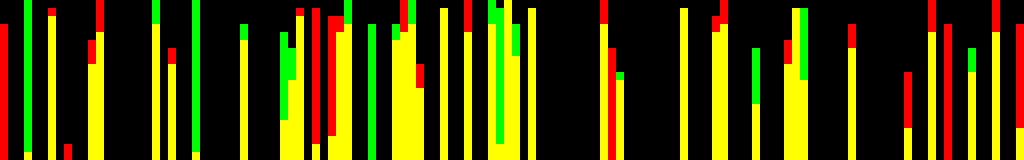

In [72]:
img.resize((1024, 160))

In [76]:
len(Selector(0,2))

0